### Análise do ano de 2020

Utilizando como base o trabalho descrito em "https://sol.sbc.org.br/index.php/bwaif/article/view/24959", este notebook desenvolverá um alocador de portfólio baseado em aprendizado por reforço, sendo sua performance avaliada ao longo do ano de 2020.

In [1]:
# Importação do diretório atual de trabalho
import sys
upper_path = sys.path[0][:-8]
sys.path.append(upper_path)

# Importação d0 módulo responsável por criar o banco de dados personalizado
from quantamental_lib import RLDatabase

# Importação de bibliotecas auxiliares
import pandas as pd
import torch


In [2]:
# Criação dos bancos de dados. Os dados de treino e teste são igualmente distribuídos com base na quantidade máxima de ativos selecionada (30).
rl_db = RLDatabase(end_train = '2019-12-31',end_test='2020-12-31', test_time_window=50)

# Leitura ou criação dos DataFrames de treino e teste
try:
    train_df = pd.read_csv('train_test_dfs/train_2020.csv')
except:
    train_df = rl_db.create_train_database()
    train_df.to_csv('train_test_dfs/train_2020.csv', index=False)

try:
    test_df = pd.read_csv('train_test_dfs/test_2020.csv')
except:
    test_df = rl_db.create_test_database()
    test_df.to_csv('train_test_dfs/test_2020.csv', index=False)

# Universo de tickers disponíveis
br_tickers = train_df.tic.unique()

print(br_tickers)

['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'BHIA3' 'CIEL3' 'CMIG4' 'COGN3' 'CPLE6'
 'CSAN3' 'CSNA3' 'ENEV3' 'FNOR11' 'GGBR4' 'GOAU4' 'GOLL4' 'ITSA4' 'ITUB4'
 'JBSS3' 'MGLU3' 'MRFG3' 'OIBR3' 'PETR3' 'PETR4' 'POMO4' 'PRIO3' 'RADL3'
 'USIM5' 'VALE3' 'WEGE3']


### Treino do modelo

O ambiente será treinado ao longo de 100 episódios, sendo sua taxa de aprendizado igual a 0.001.

In [3]:
# Importação do módulo contendo as principais classes necessárias para o treinamento
from quantamental_lib.finRL_POE import *

# Definição das features que serão avaliados pelo modelo
features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'mom', 'cci', 'stoch',
       'williams', 'macd', 'macd_signal', 'bband', 'USD/BRL', 'IBOV', 'SPX',
       'DJI', 'CDI', 'NASDAQ', 'IPCA', 'SELIC', 'IGPM', 'day']


In [3]:
# Ambiente de Treino
environment = PortfolioOptimizationEnv(
        train_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Treinamento do modelo
algo = PG(environment, lr=0.001, portfolio_size = len(br_tickers))
algo.train(episodes=100)

# Salvando o modelo treinado
torch.save(algo.target_policy.state_dict(), "trained_models/policy_EIIE_2020.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 431957.46875
Final accumulative portfolio value: 4.3195746875
Maximum DrawDown: -0.4915353481577269
Sharpe ratio: 1.104624696027127
Initial portfolio value:100000
Final portfolio value: 445321.40625
Final accumulative portfolio value: 4.4532140625
Maximum DrawDown: -0.4861160825791404
Sharpe ratio: 1.1275944214349618
Initial portfolio value:100000
Final portfolio value: 455650.75
Final accumulative portfolio value: 4.5565075
Maximum DrawDown: -0.4798796818525841
Sharpe ratio: 1.146391113326391
Initial portfolio value:100000
Final portfolio value: 468729.71875
Final accumulative portfolio value: 4.6872971875
Maximum DrawDown: -0.4726964740415678
Sharpe ratio: 1.1712000910386065
Initial portfolio value:100000
Final portfolio value: 486839.625
Final accumulative portfolio value: 4.86839625
Maximum DrawDown: -0.46217634501947313
Sharpe ratio: 1.2054129149168162
Initial portfolio value:100000
Final portfolio value: 511620.78125
Final acc

## Teste do modelo

Após o treinamento, será criado um novo ambiente de teste utilizado para a avaliação de sua performance no ano de 2020.

In [4]:
# Ambiente de teste
environment_test = PortfolioOptimizationEnv(
        test_df,
        initial_amount=100000,
        comission_fee_pct=0,
        time_window=50,
        features=features
    )

# Importação e preparação do modelo treinado
policy = GradientPolicy()
policy.load_state_dict(torch.load("trained_models/policy_EIIE_2020.pt"))
policy = policy.to(device)

# Obtenção das métricas ao longo de 2020
done = False
obs = environment_test.reset()
pvm = PVM(environment_test.episode_length, portfolio_size=len(br_tickers))
while not done:
    last_action = pvm.retrieve()
    obs_batch = np.expand_dims(obs, axis=0)
    last_action_batch = np.expand_dims(last_action, axis=0)
    action = policy(obs_batch, last_action_batch)
    pvm.add(action)
    obs, _, done, _ = environment_test.step(action)


Initial portfolio value:100000
Final portfolio value: 81298.71875
Final accumulative portfolio value: 0.8129871875
Maximum DrawDown: -0.505664058996476
Sharpe ratio: -0.10874576652472008


## Avaliação dos resultados

Realização de uma análise da performance ao longo de 2020.

In [5]:
# Importação do módulo responsável por avaliar a performance doo modelo ao longo de seu teste
from quantamental_lib import Backtest

bk = Backtest(test_environment= environment_test, portfolio_vector = pvm)

In [6]:
# Criação de um DataFrame contendo os retornos da estratégia e dos principais benchmarks (CDI e IBOV)
df = bk.general_cumulative_daily_returns()

# Salva o DataFrame em um arquivo CSV
df.to_csv('results_df/results_2020.csv', index=True)

display(df)

,Cumulative Daily Returns,IBOV,CDI
2020-01-02,1.000000,1.000000,1.000171
2020-01-03,0.995169,0.992696,1.000342
2020-01-06,0.993488,0.985705,1.000513
2020-01-07,1.008200,0.983883,1.000684
2020-01-08,1.024589,0.980383,1.000855
...,...,...,...
2020-12-22,0.779807,0.981235,1.027118
2020-12-23,0.785645,0.993962,1.027194
2020-12-28,0.794208,1.004031,1.027348
2020-12-29,0.811095,1.007607,1.027425


In [9]:
# Avaliação do índice de Sharpe do modelo
sharpe_ratio = bk.sharpe_ratio(risk_free_rate=0)
print('Sharpe Ratio: ', sharpe_ratio)

# Avaliação do índice de acerto do modelo
hit_ratio = bk.hit_ratio()
print('Hit ratio: ', hit_ratio)

Sharpe Ratio:  -0.09443548378388256
Hit ratio:  0.49382716049382713


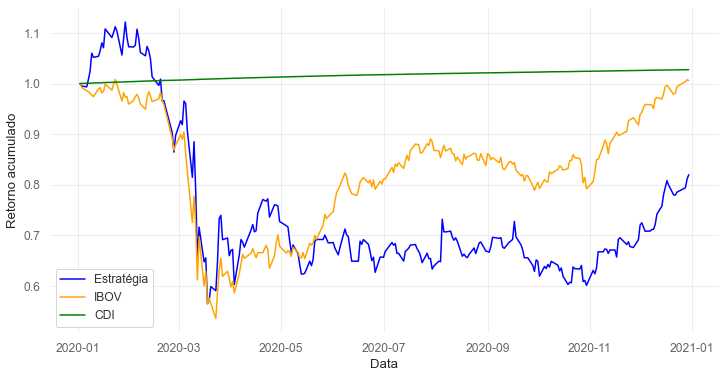

In [8]:
# Plotagem dos resultados para facilitar sua comparação
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) 

plt.plot(df['Cumulative Daily Returns'], label='Estratégia', color ='blue')  
plt.plot(df['IBOV'], label='IBOV', color ='orange')  
plt.plot(df['CDI'], label='CDI', color ='green')  

plt.legend()

plt.ylabel('Retorno acumulado')
plt.xlabel('Data')

plt.show()